In [2]:
import cv2 as cv
import imutils
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
def display_image(img, figsize=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(imutils.opencv2matplotlib(img))

In [ ]:
def get_images(root_dir):
    images = []
    walk = list(os.walk(root_dir))
    classes = walk[0][1]
    for idx, path in enumerate(walk[1:]):
        for fname in path[2]:
            image = cv.imread(os.path.join(path[0], fname))
            images.append((classes[idx], image))
    return images

images = get_images('2b')

In [ ]:
print(images)
display_image(images[0][1])

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
from sklearn.cluster import KMeans
def generate_dictionary(images, feature_selector='SIFT', num_words=-1, random_state=42):
    descriptors = []
    for _, img in images:
        if feature_selector == 'SURF':
            extractor = cv.xfeatures2d_SURF().create()
        else:
            extractor = cv.SIFT_create()
        _, desc = extractor.detectAndCompute(img, None)
        descriptors.append(desc)
        # print(desc.shape)

    descriptorMatrix = np.vstack(descriptors)
    # print(descriptorMatrix.shape)
    if num_words == -1:
        kmeans = KMeans(n_clusters=int(np.sqrt(descriptorMatrix.shape[0])), random_state=random_state)
    else:
        kmeans = KMeans(n_clusters=num_words, random_state=random_state)
    kmeans.fit(descriptorMatrix)
    return kmeans

cluster = generate_dictionary(images, num_words=200)

In [ ]:
cluster.n_clusters

200

In [ ]:
def vectorize_image(image, cluster, feature_selector='SIFT'):
    num_features = cluster.n_clusters
    features = np.zeros(num_features)
    if feature_selector == 'SURF':
            extractor = cv.xfeatures2d_SURF().create()
    else:
        extractor = cv.SIFT_create()
    _, desc = extractor.detectAndCompute(image, None)
    res = cluster.predict(desc)
    for obs in res:
        features[obs] += 1
    return features

vectorize_image(images[0][1], cluster)

array([ 2.,  2.,  3.,  1.,  9.,  1.,  1.,  3.,  1.,  1.,  3.,  7.,  1.,
        1.,  2.,  5.,  6.,  1.,  4.,  1.,  3.,  4.,  3.,  8.,  3.,  2.,
        1.,  4.,  9.,  1.,  3.,  1.,  8.,  2.,  2.,  3.,  7.,  1.,  7.,
        1.,  0.,  1.,  3.,  2.,  3.,  4.,  5.,  4.,  2.,  2.,  8.,  5.,
        0.,  6.,  3.,  7.,  7.,  1.,  4.,  4.,  1.,  5.,  5.,  5., 14.,
        5.,  6.,  3.,  7.,  8.,  5.,  1.,  2.,  2.,  1.,  3.,  1.,  3.,
        6.,  8.,  3.,  1.,  4.,  2.,  4.,  2.,  6.,  5.,  4.,  2.,  1.,
        1.,  4.,  0.,  1.,  3.,  2.,  1.,  6., 12.,  1.,  6.,  1.,  3.,
        2.,  4.,  2.,  3.,  4.,  1.,  4.,  0.,  2.,  3.,  6.,  2.,  3.,
        4.,  0.,  2.,  4.,  2.,  0.,  2.,  5.,  0.,  1.,  7.,  1.,  2.,
        4.,  7.,  3.,  3.,  1.,  1.,  1.,  3.,  6.,  6.,  2.,  6.,  1.,
        2.,  4.,  1.,  2.,  6.,  3.,  0.,  3.,  4.,  5.,  1.,  5.,  1.,
        1.,  3.,  2.,  4.,  5.,  2.,  1.,  4.,  4.,  5.,  0.,  0.,  2.,
        5.,  1.,  2.,  1.,  6.,  0.,  3.,  8.,  2.,  3.,  4.,  3

In [ ]:
vectorized_images = []
for img in images:
    vectorized_image = vectorize_image(img[1], cluster)
    vectorized_images.append(vectorized_image)
vectorized_images = np.vstack(vectorized_images)
vectorized_images

array([[ 2.,  2.,  3., ...,  2.,  5.,  8.],
       [ 2.,  4.,  3., ...,  2.,  5.,  5.],
       [ 2.,  4.,  4., ...,  5.,  4., 13.],
       ...,
       [ 2.,  2.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  0., ...,  2.,  2.,  2.],
       [15.,  5., 12., ...,  7.,  5., 10.]])

### Without TF-IDF

In [ ]:
X = vectorized_images.copy()
y = np.array([img[0] for img in images])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)
le.classes_

array(['Bikes', 'Horses'], dtype='<U6')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

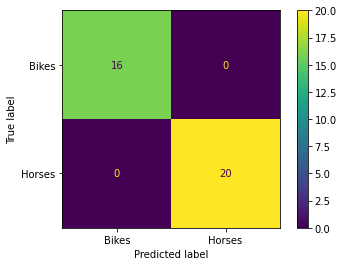

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()

In [ ]:
accuracy_score(y_test, y_pred)

1.0

In [ ]:
roc_auc_score(y_test, y_proba)

1.0

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

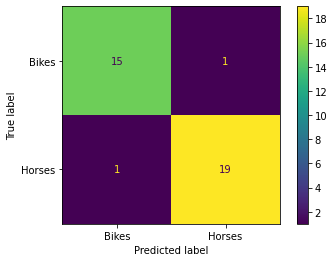

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()

In [ ]:
accuracy_score(y_test, y_pred)

0.9444444444444444

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

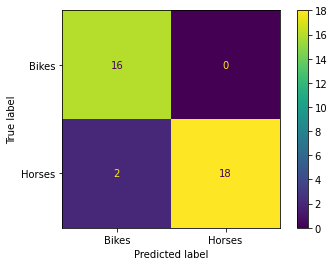

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()

In [ ]:
accuracy_score(y_test, y_pred)

0.9444444444444444

In [ ]:
roc_auc_score(y_test, y_proba)

0.978125

### With TF-IDF

In [ ]:
X = vectorized_images.copy()
y = np.array([img[0] for img in images])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)
le.classes_

array(['Bikes', 'Horses'], dtype='<U6')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

In [ ]:
def tfidf_transform(train, test):
    from sklearn.feature_extraction.text import TfidfTransformer

    tfidf = TfidfTransformer(sublinear_tf=True)
    tfidf_train = tfidf.fit_transform(train)
    tfidf_test = tfidf.transform(test)
    return tfidf_train, tfidf_test

X_train, X_test = tfidf_transform(X_train, X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

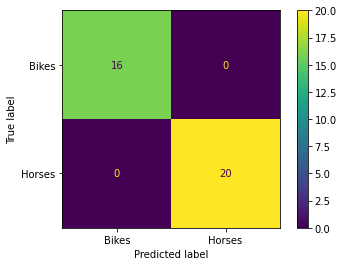

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()

In [ ]:
accuracy_score(y_test, y_pred)

1.0

In [ ]:
roc_auc_score(y_test, y_proba)

1.0

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

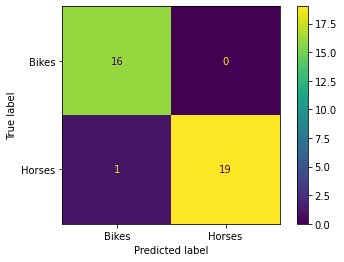

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()

In [ ]:
accuracy_score(y_test, y_pred)

0.9722222222222222

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

C:\Users\venka\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\daal4py\sklearn\neighbors\_base.py:361: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)


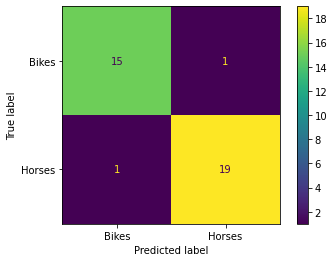

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()

In [ ]:
accuracy_score(y_test, y_pred)

0.9444444444444444

In [ ]:
roc_auc_score(y_test, y_proba)

0.965625

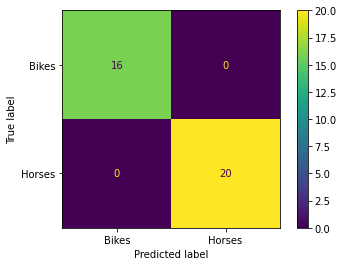

In [ ]:
from sklearn.svm import SVC

svc = LogisticRegression()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_).plot()